# DATA PROJECT - JPS

In this project we analyse the development of the house and aparment prices in Denmark. We compare the prices and growth rate of houses and apartments in Copenhagen as well as the difference of the change in prices between counties in Denmark. 

Importing the needed packages:

In [1]:
%pip install pandas-datareader
%pip install git+https://github.com/elben10/pydst
%pip install matplotlib-venn

import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import ipywidgets as widgets
from matplotlib_venn import venn2
from scipy.stats.mstats import gmean

import pandas_datareader 
import pydst 

# autoreload modules when code is run
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
plt.rcParams.update({"axes.grid":True,"grid.color":"black","grid.alpha":"0.25","grid.linestyle":"--"})
plt.rcParams.update({'font.size': 14})

# user written modules
import dataproject


  Cloning https://github.com/elben10/pydst to c:\users\psand\appdata\local\temp\pip-req-build-3tzs08s8
  Resolved https://github.com/elben10/pydst to commit bb347560a1b3c17684fda072c829658da38f5a72
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
Note: you may need to restart the kernel to use updated packages.


  Running command git clone --filter=blob:none --quiet https://github.com/elben10/pydst 'C:\Users\PSand\AppData\Local\Temp\pip-req-build-3tzs08s8'


Note: you may need to restart the kernel to use updated packages.


# Read and clean data

Importing and cleaning the data for apartments

In [2]:
# Loading the Data from statistikbanken
filename1 = 'Ejerlejligheder.xlsx'
pd.read_excel(filename1).head(5)

,"Ejendomssalg efter overdragelsesformer, nøgletal, ejendomskategori, område og tid",Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 25,Unnamed: 26,Unnamed: 27,Unnamed: 28,Unnamed: 29,Unnamed: 30,Unnamed: 31,Unnamed: 32,Unnamed: 33,Unnamed: 34
0,Enhed: -,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,1992.0,1993.0,1994.0,1995.0,1996.0,1997.0,...,2013.0,2014.0,2015.0,2016.0,2017.0,2018.0,2019.0,2020.0,2021.0,2022.0
2,Almindelig fri handel,Gennemsnitlig pris pr. ejendom (1000 kr),"Ejerlejligheder, i alt",Hele landet,421.0,419.0,452.0,474.0,514.0,536.0,...,1845.0,1945.0,2063.0,2156.0,2369.0,2470.0,2570.0,2800.0,3005.0,2847.0
3,NaN,NaN,NaN,Region Hovedstaden,446.0,443.0,482.0,502.0,538.0,557.0,...,2166.0,2236.0,2351.0,2511.0,2813.0,2958.0,3066.0,3351.0,3664.0,3520.0
4,NaN,NaN,NaN,Landsdel Byen København,421.0,417.0,453.0,475.0,510.0,529.0,...,2341.0,2411.0,2570.0,2798.0,3182.0,3355.0,3449.0,3730.0,4174.0,4026.0


In [3]:
# Now we are dropping rows
ap = pd.read_excel(filename1, skiprows=2)

# Now we drop the first three columns
del ap['Unnamed: 0'], ap['Unnamed: 1'], ap['Unnamed: 2']

# Now we rename the variable 'Unnamed: 3' 
ap.rename(columns = {'Unnamed: 3':'County'},inplace=True)
col_dict = {}
for i in range(1992, 2022+1): # range goes from 2008 to but not including 2018
    col_dict[str(i)] = f'AP_price{i}' 
ap.rename(columns = col_dict, inplace=True)

# We are only interesetd in the Countys so we drop the regions and the whole country
I = ap.County.str.contains('Region')
I |= ap.County.str.contains('Hele landet')
ap.loc[I, :]
ap = ap.loc[I == False]

# We reset the index 
ap.reset_index(inplace = True, drop = True) # Drop old index too
ap.iloc[0:5,:]

# We convert the index from wide to long
ap_long = pd.wide_to_long(ap, stubnames='AP_price', i='County', j='Year')
ap_long.head(11)

,,AP_price
County,Year,
Landsdel Byen København,1992,421
Landsdel Københavns omegn,1992,474
Landsdel Nordsjælland,1992,504
Landsdel Bornholm,1992,377
Landsdel Østsjælland,1992,466
Landsdel Vest- og Sydsjælland,1992,338
Landsdel Fyn,1992,338
Landsdel Sydjylland,1992,374
Landsdel Østjylland,1992,434


Importing and cleaning the data for Houses

In [4]:
# Loading the Data from statistikbanken
filename2 = 'Familiehuse.xlsx'
pd.read_excel(filename2).head(5)

,"Ejendomssalg efter overdragelsesformer, nøgletal, ejendomskategori, område og tid",Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 25,Unnamed: 26,Unnamed: 27,Unnamed: 28,Unnamed: 29,Unnamed: 30,Unnamed: 31,Unnamed: 32,Unnamed: 33,Unnamed: 34
0,Enhed: -,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,1992.0,1993.0,1994.0,1995.0,1996.0,1997.0,...,2013.0,2014.0,2015.0,2016.0,2017.0,2018.0,2019.0,2020.0,2021.0,2022.0
2,Almindelig fri handel,Gennemsnitlig pris pr. ejendom (1000 kr),Enfamiliehuse,Hele landet,551.0,565.0,622.0,656.0,753.0,806.0,...,1883.0,1955.0,2082.0,2122.0,2209.0,2257.0,2335.0,2477.0,2639.0,2464.0
3,NaN,NaN,NaN,Region Hovedstaden,777.0,789.0,876.0,935.0,1088.0,1195.0,...,2965.0,3075.0,3310.0,3465.0,3623.0,3754.0,3873.0,4231.0,4723.0,4471.0
4,NaN,NaN,NaN,Landsdel Byen København,767.0,785.0,856.0,917.0,1063.0,1169.0,...,3535.0,3775.0,4129.0,4441.0,4725.0,4938.0,5128.0,5708.0,6198.0,6146.0


In [5]:
# Now we are dropping rows
house = pd.read_excel(filename2, skiprows=2)

# Now we drop the first three columns
del house['Unnamed: 0'], house['Unnamed: 1'], house['Unnamed: 2']

# Now we rename the variable 'Unnamed: 3' 
house.rename(columns = {'Unnamed: 3':'County'},inplace=True)
col_dict = {}
for i in range(1992, 2022+1): # range goes from 2008 to but not including 2018
    col_dict[str(i)] = f'House_price{i}' 
house.rename(columns = col_dict, inplace=True)

# We are only interesetd in the Countys so we drop the regions and the whole country
J = house.County.str.contains('Region')
J |= house.County.str.contains('Hele landet')
house.loc[I, :]
house = house.loc[I == False]

# We reset the index 
house.reset_index(inplace = True, drop = True) # Drop old index too
house.iloc[0:5,:]

# We convert the index from wide to long
house_long = pd.wide_to_long(house, stubnames='House_price', i='County', j='Year')
house_long.head(11)

,,House_price
County,Year,
Landsdel Byen København,1992,767
Landsdel Københavns omegn,1992,836
Landsdel Nordsjælland,1992,797
Landsdel Bornholm,1992,335
Landsdel Østsjælland,1992,704
Landsdel Vest- og Sydsjælland,1992,445
Landsdel Fyn,1992,470
Landsdel Sydjylland,1992,494
Landsdel Østjylland,1992,557


## Plotting the data

We are plotting the prices on houses and apartments in København to compare the development.

<AxesSubplot: xlabel='Year'>

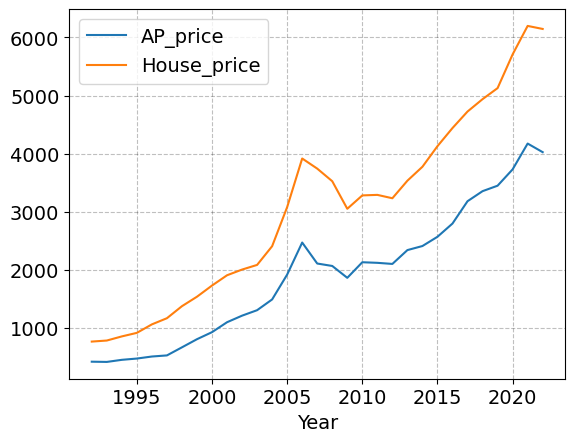

In [6]:
# Data with København Apartments
ap_long_2 = ap_long.reset_index()
ap_long_2.loc[ap_long_2.County == 'Landsdel Byen København', :] 
ap_københavn = ap_long_2.loc[ap_long_2['County'] == 'Landsdel Byen København', :]

# Data with København Houses
house_long_2 = house_long.reset_index()
house_long_2.loc[house_long_2.County == 'Landsdel Byen København', :]
house_københavn = house_long_2.loc[house_long_2['County'] == 'Landsdel Byen København', :]
# Data with Nordjylland
house_long_3 = house_long.reset_index()
house_long_3.loc[house_long_3.County == 'Landsdel Nordjylland', :]
house_nordjylland = house_long_3.loc[house_long_3['County'] == 'Landsdel Nordjylland', :]

# Plotting
ax = ap_københavn.plot(x='Year', y='AP_price', label = 'AP_price')
house_københavn.plot(x='Year', y='House_price', ax=ax)



The prices in Copenhagen has increased a lot the last 30 years. One factor that has contributed to the rise in house prices in the recent years, is the low interest rate. This has made it more affordable til take out mortages and purchase homes. 
The increased prices on apartments and house has almost been the same over the past 30 years

Interactive plot showing the development of the prices on houses in the different counties in Denmark.

In [7]:
# defiition of the plot function
def plot_func(df, County):
    # Function that operates on data set
    I = df['County'] == County
    ax=df.loc[I,:].plot(x='Year', y='House_price', style='-o', legend=False)
 # setting the interactive widget
widgets.interact(plot_func, 
    df = widgets.fixed(house_long_2),
    County = widgets.Dropdown(description='County', 
                                    options=house_long_2.County.unique(), 
                                    value='Landsdel Byen København')
);


interactive(children=(Dropdown(description='County', options=('Landsdel Byen København', 'Landsdel Københavns …

The change in houseprices has been more volatile in the big cities in the Denmark compared to the small cities. The financial crisis has made a bigger decrease on the house prices in Copenhagen than in Nordjylland. 

# Merge data sets

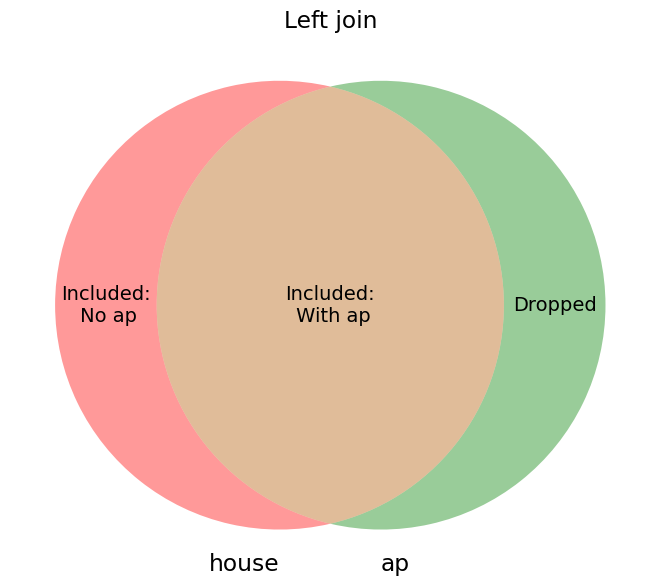

In [8]:
plt.figure(figsize=(15,7))
v = venn2(subsets = (4, 4, 10), set_labels = ('house', 'ap'))
v.get_label_by_id('100').set_text('Included:\n No ap')
v.get_label_by_id('010').set_text('Dropped' )
v.get_label_by_id('110').set_text('Included:\n With ap')
plt.title('Left join')
plt.show()

Merging the data

In [9]:
# We make a left join merge 
join = pd.merge(house, ap, on='County', how='left')
join.head(10)


,County,House_price1992,House_price1993,House_price1994,House_price1995,House_price1996,House_price1997,House_price1998,House_price1999,House_price2000,...,AP_price2013,AP_price2014,AP_price2015,AP_price2016,AP_price2017,AP_price2018,AP_price2019,AP_price2020,AP_price2021,AP_price2022
0,Landsdel Byen København,767,785,856,917,1063,1169,1376,1539,1731,...,2341,2411,2570,2798,3182,3355,3449,3730,4174,4026
1,Landsdel Københavns omegn,836,844,955,1029,1204,1321,1472,1628,1784,...,1761,1812,1846,1947,2112,2229,2389,2556,2747,2686
2,Landsdel Nordsjælland,797,810,901,965,1126,1226,1373,1536,1674,...,1690,1748,1834,1782,1964,2128,2112,2307,2521,2439
3,Landsdel Bornholm,335,341,368,388,434,453,475,496,531,...,607,679,700,875,898,657,809,895,1274,948
4,Landsdel Østsjælland,704,716,813,879,1013,1106,1240,1338,1467,...,1406,1387,1582,1723,1787,1938,2093,2302,2495,2383
5,Landsdel Vest- og Sydsjælland,445,457,490,517,567,616,675,732,795,...,906,958,999,1058,1076,1087,1133,1179,1268,1259
6,Landsdel Fyn,470,477,523,555,639,686,785,816,860,...,1149,1198,1354,1340,1438,1585,1651,1750,1757,1770
7,Landsdel Sydjylland,494,508,559,583,664,704,754,810,852,...,1089,1083,1191,1177,1231,1366,1450,1407,1546,1506
8,Landsdel Østjylland,557,564,626,662,774,820,910,971,1035,...,1582,1690,1791,1825,1973,2017,2145,2272,2476,2363
9,Landsdel Vestjylland,471,483,530,558,617,646,699,737,767,...,1069,1017,1065,1047,1127,1152,1168,1137,1259,1221


In [10]:
join_long = join.melt(id_vars=['County'], var_name = 'Year', value_name='Price')
join_long['Type'] = join_long['Year'].str[:-4]
join_long['Year'] = join_long['Year'].str[-4:]
join_long['County'] = join_long['County'].str.slice(start=9)
join_long.sort_values(['Year', 'County'], ignore_index=True)

,County,Year,Price,Type
0,Bornholm,1992,335,House_price
1,Bornholm,1992,377,AP_price
2,Byen København,1992,767,House_price
3,Byen København,1992,421,AP_price
4,Fyn,1992,470,House_price
...,...,...,...,...
677,Vestjylland,2022,1221,AP_price
678,Østjylland,2022,2655,House_price
679,Østjylland,2022,2363,AP_price
680,Østsjælland,2022,3684,House_price


# Analysis

In the analysis we are comparing the growth rate and the geometric mean in house and apartment prices in Copenhagen

In [22]:
# We calculate the growthrate and the geometric mean
house_københavn['Growth_Rate'] = (house_københavn['House_price'].pct_change(periods=1) * 100)
# We drop the NaN value from the dataset 
house_københavn2 = house_københavn.tail(-1)
gm1 = (gmean(house_københavn2['Growth_Rate'] / 100 + 1)-1)*100
print ("%.2f" % gm1)
house_københavn2['Gmean'] = gm1
house_københavn2['D_Gmean'] = house_københavn2.Growth_Rate - house_københavn2.Gmean
house_københavn2.head(10)

7.18


C:\Users\PSand\AppData\Local\Temp\ipykernel_3568\1785150396.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  house_københavn['Growth_Rate'] = (house_københavn['House_price'].pct_change(periods=1) * 100)
C:\Users\PSand\AppData\Local\Temp\ipykernel_3568\1785150396.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  house_københavn2['Gmean'] = gm1
C:\Users\PSand\AppData\Local\Temp\ipykernel_3568\1785150396.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try 

,County,Year,House_price,Growth_Rate,Gmean,D_Gmean
11,Landsdel Byen København,1993,785,2.346806,7.183164,-4.836358
22,Landsdel Byen København,1994,856,9.044586,7.183164,1.861422
33,Landsdel Byen København,1995,917,7.126168,7.183164,-0.056996
44,Landsdel Byen København,1996,1063,15.921483,7.183164,8.738319
55,Landsdel Byen København,1997,1169,9.971778,7.183164,2.788614
66,Landsdel Byen København,1998,1376,17.707442,7.183164,10.524278
77,Landsdel Byen København,1999,1539,11.845930,7.183164,4.662766
88,Landsdel Byen København,2000,1731,12.475634,7.183164,5.292470
99,Landsdel Byen København,2001,1908,10.225303,7.183164,3.042139
110,Landsdel Byen København,2002,2006,5.136268,7.183164,-2.046896


In [28]:
# We calculate the growthrate and the geometric mean
ap_københavn['Growth_Rate'] = (ap_københavn['AP_price'].pct_change(periods=1) * 100)
# We drop the NaN value from the dataset 
ap_københavn2 = ap_københavn.tail(-1)
gm2 = (gmean(ap_københavn2['Growth_Rate'] / 100 + 1)-1)*100
print ("%.2f" % gm2)
ap_københavn2['Gmean'] = gm2
ap_københavn2['D_Gmean'] = ap_københavn2.Growth_Rate - ap_københavn2.Gmean
ap_københavn2.head(10)

7.82


C:\Users\PSand\AppData\Local\Temp\ipykernel_3568\801238426.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ap_københavn['Growth_Rate'] = (ap_københavn['AP_price'].pct_change(periods=1) * 100)
C:\Users\PSand\AppData\Local\Temp\ipykernel_3568\801238426.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ap_københavn2['Gmean'] = gm2
C:\Users\PSand\AppData\Local\Temp\ipykernel_3568\801238426.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_

,County,Year,AP_price,Growth_Rate,Gmean,D_Gmean
11,Landsdel Byen København,1993,417,-0.950119,7.816788,-8.766907
22,Landsdel Byen København,1994,453,8.633094,7.816788,0.816306
33,Landsdel Byen København,1995,475,4.856512,7.816788,-2.960276
44,Landsdel Byen København,1996,510,7.368421,7.816788,-0.448367
55,Landsdel Byen København,1997,529,3.725490,7.816788,-4.091298
66,Landsdel Byen København,1998,668,26.275992,7.816788,18.459205
77,Landsdel Byen København,1999,808,20.958084,7.816788,13.141296
88,Landsdel Byen København,2000,929,14.975248,7.816788,7.158460
99,Landsdel Byen København,2001,1100,18.406889,7.816788,10.590101
110,Landsdel Byen København,2002,1213,10.272727,7.816788,2.455939


Plotting growth rate and the geometric mean of the house and apartments in Copenhagen

c:\Users\PSand\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:807: UserWarning: The label '_nolegend_' of <matplotlib.lines.Line2D object at 0x00000215A6F81550> starts with '_'. It is thus excluded from the legend.
  ax.legend(handles, labels, loc="best", title=title)
c:\Users\PSand\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:807: UserWarning: The label '_nolegend_' of <matplotlib.lines.Line2D object at 0x00000215A6FAF790> starts with '_'. It is thus excluded from the legend.
  ax.legend(handles, labels, loc="best", title=title)


<AxesSubplot: title={'center': 'Growth rate, City of Copenhagen'}, xlabel='Year'>

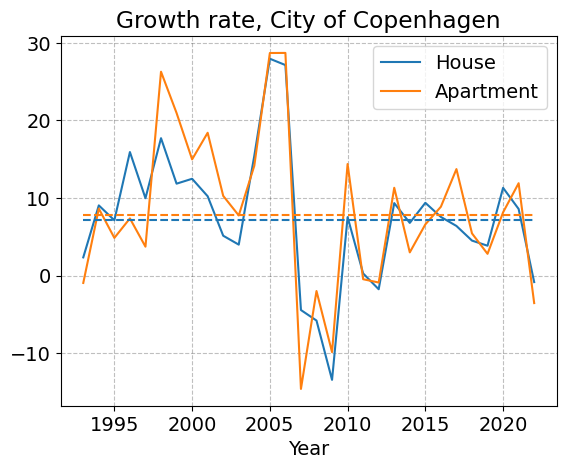

In [35]:
# Plotting growth rate and the geometric mean
ax = house_københavn2.plot(x='Year', y='Growth_Rate', label = 'House')
ax = ap_københavn2.plot(x='Year', y='Growth_Rate', label = 'Apartment', ax=ax)
ax = house_københavn2.plot(x='Year', y='Gmean', color='tab:blue', linestyle='--', label='_nolegend_', ax=ax)
ap_københavn2.plot(x='Year', y='Gmean', color='tab:orange', linestyle='--', label='_nolegend_', title='Growth rate, City of Copenhagen', ax=ax)


# Conclusion

In this project we have plotted the house prices, the growth rate and the geometric mean. 
It has been shows that there has been an significant increase in the house prices especially in Copenhagen. It has also been shown that the crisis in 2008 made a fluctuation in the prices, which has the biggest effect in the capital, Copnehagen, 